# D213 - Advanced Data Analytics
### NLM3 Task 1: Time Series Modeling
#### Advanced Data Analytics — D213
#### PRFA — NLM3
> André Davis
> StudentID: 010630641
> MSDA
>
> Competencies
> 4030.7.2 : Time Series Analysis
> The graduate applies time series models in generating forecasts. 

#### Table of Contents
<ul>
    <li><a href="#research-question">A1: Research Question</a></li>
    <li><a href="#objectives">A2: Objectives and Goals of Analysis</a></li>
    <li><a href="#assumptions">B: Assumptions of Time Series Model</a></li>
    <li><a href="#visualizations">C1: Time Series Visualization</a></li>
    <li><a href="#time-step-description">C2: Time Step Formatting Description</a></li>
    <li><a href="#stationary-of-series">C3: Stationarity Evaluation</a></li>
    <li><a href="#data-preparation">C4: Data Preparation Steps & Training and Test Data Split</a></li>
    <li><a href="#copy-of-prepared-data">C5: Copy of Cleaned Data Set</a></li>
    <li><a href="#annotated-findings-and-visualizations">D1: Report the annotated findings with visualizations of data analysis</a></li>
    <li><a href="#arima-model-of-time-series-data">D2: ARIMA Model - Observed Trend and Seasonality of Time Series</a></li>
    <li><a href="#forcast">D3: Forecast of ARIMA Model</a></li>
    <li><a href="#analysis">D4: Calculations and Outputs of Analysis</a></li>
    <li><a href="#arima-code">D5: Time-Serires Model Code</a></li>
    <li><a href="#results-of-analysis">E1: Data Analysis Results</a></li> 
    <li><a href="#forcast-visualizations">E2: Annotated Visualization of Forecase (Test Set)</a></li> 
    <li><a href="#recommendations">E3: Recommended Course of Action</a></li>
    <li><a href="#reporting">F: Reporting</a></li>
    <li><a href="#code-references">G: Code References</a></li>
    <li><a href="#source-references">H: Source References</a></li>    
</ul>

# Part I: Research Question

<a id="research-question"></a>
## A1: Research Question

The research question explored in this report is: "Is it possible to accurately and effectively forecast the daily revenues of [`WGU`](https://www.wgu.edu/) Hospital System in a manner that aligns closely with the actual observed daily revenues?"

<a id="objectives"></a>
## A2: Objectives and Goals of Analysis

The objective of this analysis is to accurately predict daily revenues for the [`WGU`](https://www.wgu.edu) Hospital System utilizing the available [`dataset`](https://access.wgu.edu/ASP3/aap/content/fj30d8sm59fc83ed9xsi.zip). The analysis employs an 80-20 split of the dataset, using the initial 80% as a training set to forecast the remaining 20%, which serves as a test set. This approach allows for the use of observed values as a benchmark for comparison. An ARIMA time series model will be utilized to analyze the training set and project the values in the test set.

> ARIMA is a "model runs *d* rounds of differencing to make the time series more stationary, then it applies a regular ARMA Model. When making forecasts, it uses this ARMA model, then it adds back the terms that were subtracted by differencing."(Géron, 2022).

# Part II: Method Justification

<a id="assumptions"></a>
## B: Assumptions of Time Series Model

>The submission accurately summarizes each of the assumptions of a time series model. The summary includes stationarity and autocorrelated data.

Assumptions of the ARMA Family of Models, including ARIMA include:

 1. Data must not include outliers and/or anomalies 
 2. The time series data should exhibit stationary, devoid of any trends or seasonal fluctuations.
 3. Datapoints in the past must be indicative of future datapoints in behavior.
 4. The data must reflect a single variable and be classified as uni-variate to be modelled.
 5. The data must be auto-correlated for ARIMA model to perform forecasting via Autoregressive Component 

Some observational notes about the [`WGU Medical Time Series Dataset`](https://access.wgu.edu/ASP3/aap/content/fj30d8sm59fc83ed9xsi.zip) and the assumption point #3. Because this is a Performance Assessment for graduate school, the data presented for this activity is pretty limited. There are 730 rows and because this is a daily record, this equals 2 years of daily data. It may or may not be enough information to know if the past data indicates future behavior.

# Part III: Data Preparation

<a id="visualizations"></a>
## C1: Time Series Visualization

In [2]:

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from scipy import signal

warnings.filterwarnings('ignore')

medical_daily_revenue = pd.read_csv('./medical_time_series.csv')
medical_daily_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [3]:
'''
For a Time-Series it will be easier to work with actual dates rather than a single number in the span of 2 years.

Because this is an academic performance assessment I will use the start data of Jan 1st 2021. I'm basing this off
the year WGU was founded within "The National Society of Leadership and Success" + 1 year so the 2 year period ends in 2023 (current year of this assignment)

To index with dates pd.date_range (https://pandas.pydata.org/docs/reference/api/pandas.date_range.html) will be used.
'''

date_range_indexes = pd.date_range(start='2021', periods=len(medical_daily_revenue), freq='D')
medical_daily_revenue.set_index(date_range_indexes, inplace=True)
medical_daily_revenue.drop('Day', axis=1, inplace=True)

medical_daily_revenue.info()

print(f'\nTotal Records: [{len(medical_daily_revenue)}]')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2021-01-01 to 2023-01-01
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB

Total Records: [731]


#### Visualization of the Medical Daily Revenue Dataset

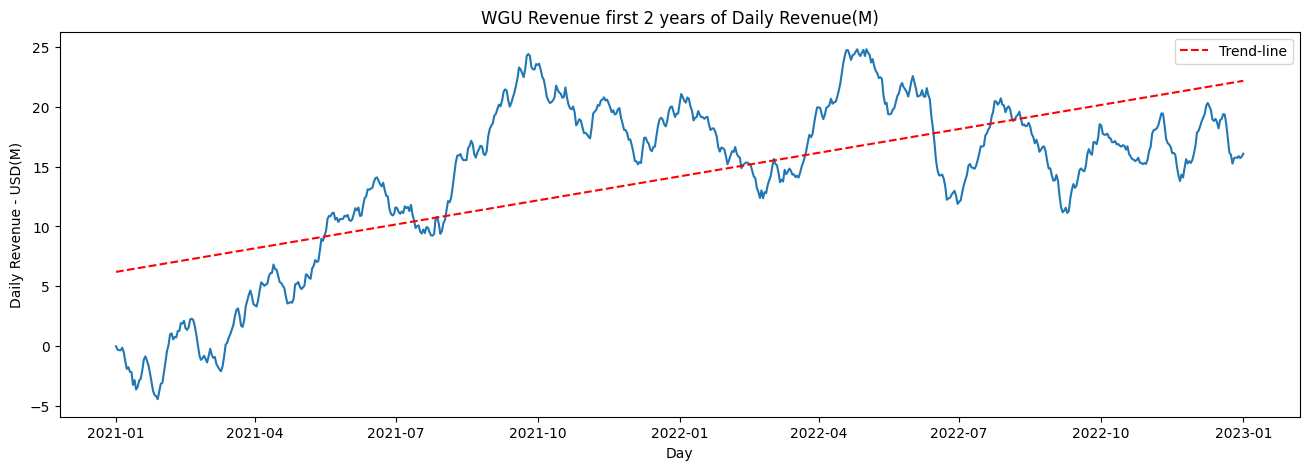

In [4]:
def chart_time_series(x: pd.Series, y: pd.Series, title: str) -> None:
    """
    :param x: x-coordinates data to plot
    :type x: pd.Series
     
    :param y: y-coordinates data to plot
    :type y: pd.Series
    
    :param title: Title for the plot
    :type title: str
    
    :return: None 
    """
    plt.figure(figsize=(16,5))
    plt.xlabel('Day')
    plt.ylabel('Daily Revenue - USD(M)')
    plt.title(f'{title} first 2 years of Daily Revenue(M)')
        
    plt.plot(x, y)
    
    #generate trend line
    date_as_num = mdates.date2num(x)
    polynomial_coefficients = np.polyfit(date_as_num, y, 1)
    polynomial_function = np.poly1d(polynomial_coefficients) 
    
    plt.plot(x, polynomial_function(date_as_num), c='r', linestyle='--', label='Trend-line')
    plt.legend()
    
    plt.show()

x_dates = medical_daily_revenue.index
y_revenue = medical_daily_revenue['Revenue']

chart_time_series(x_dates, y_revenue, 'WGU Revenue')

To initiate the Time Series Analysis, the 'Days' attribute, which originally contained values ranging from 1 to 731, was transformed into corresponding date values. These dates encapsulate a two-year period of daily revenue data for WGU Hospital, denominated in U.S. dollars. The selection of the start date was made for scholarly considerations, as the hospital's actual founding date was not provided. 

The dates and revenue data were graphically represented, accompanied by a trend-line, to facilitate the visual identification of stationarity or non-stationarity in the dataset. While an upward trend is discernible, the presence of spikes—characterized by peaks and valleys—suggests potential seasonality. Addressing this is essential for conducting a rigorous time series analysis. The stationarity of the data will be further confirmed using the [`Augmented Dickey-Fuller test`](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). 

<a id="time-step-description"></a>
## C2: Description of Time Step Formatting

The format of the time series data is pretty straight forward. We have two variables(columns) called `Day` and `Revenue`. The data represents revenue in the millions per day for two years since the opening of the *WGU Hospital*. The data does not contain any missing revenue values or days as it's a complete data set starting at Day 1 and continuing through Day 731, which is two years worth of data. The fact the total data is 731 and not 730 could indicate that the 2 years spanned through a [leap year](https://en.wikipedia.org/wiki/Leap_year) in February.

<a id="stationary-of-series"></a>
## C3: Stationary of Series

To rigorously assess the stationarity of the dataset, we will employ a dual-method approach. Initially, a secondary visual inspection will be conducted by plotting the [`Rolling Average (Moving Average)`](https://www.indeed.com/career-advice/career-development/what-is-rolling-average) alongside the original time series. Subsequently, quantitative verification will be performed using the [`Augmented Dickey-Fuller (ADF) test`](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), focusing on the p-value and ADF statistic. This combination of visual and statistical methods aims to provide a comprehensive evaluation of data stationarity.

> "Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series." (Prabhakaran, 2022)

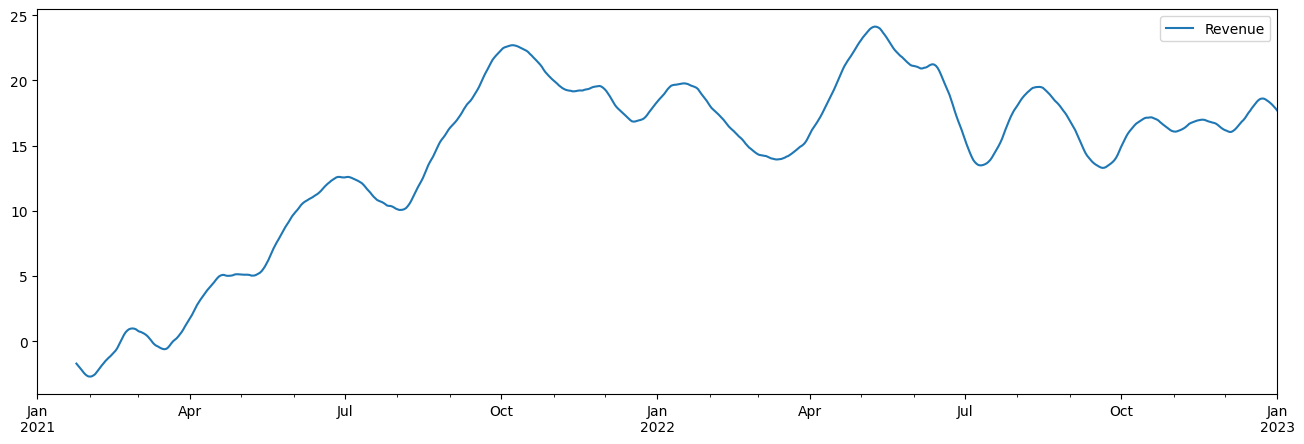

In [5]:
'''
Visually Plot Rolling Average
'''
def generate_rolling_plot(data: pd.DataFrame, window_size: int = 24) -> None:
    """
    :param data: data to performing rolling average on
    :type data: pd.DataFrame
    
    :param window_size:  number of months for the rolling average window size
    :type: window_size: int
    
    :return: None
    
    Documentation: 
        * Rolling - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
        * Mean - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html
    """
    rolling = data.rolling(window=window_size)
    rolling_means = rolling.mean()
    rolling_means.plot(figsize=(16,5))
    
generate_rolling_plot(medical_daily_revenue)

Visually checking the Rolling Average it's pretty clear that the data is not stationary. To confirm this in a statistical manner we will now do the  [`Augmented Dickey-Fuller test`](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). 

In [6]:
'''
Augmented Dickey-Fuller Documentation: 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

statsmodels.tsa.stattools.adfuller(
    x, 
    maxlag=None, 
    regression='c', 
    autolag='AIC', 
    store=False, 
    regresults=False
)
'''

def execute_adfuller(data: pd.Series, title: str) -> None:
    """   
    :param data: data to perform the Augmented Dickey-Fuller Test on
    :type data: pd.DataFrame
    
    :param title: title for the chart
    :type title: str
    
    :return: None
    """
    adf, p_value, used_lag, nobs, critical_values, icbest = adfuller(data)
    
    print(f'ADF Statistic: {adf}')
    print(f'p-value: {p_value}')
    print(f'Number of lags used: {used_lag}')
    print(f'Number of observations: {nobs}')
    print(f'Critical Values: {critical_values}')
    print(f'Maximized Information Criterion: {icbest}')
    
    print('\n')
    print('p-value Stationary Results:')
    print('=============================================================')
    is_data_stationary = p_value <= .05
    
    print(f'p-value check: {round(p_value, 4)} < .05')
    if is_data_stationary:
        print(f'{title} Time Series data is likely stationary.')
        print(f'Reject the null hypothesis (stationary) ')
    else:
        print(f'{title} Time Series data is likely non-stationary.')
        print(f'Fail to reject the null hypothesis (accept Alternative Hypothesis)')
    print('=============================================================')
    
    print('\n')
    print('adf (test statistic) Results:')
    print('=============================================================')
    
    print(f"adf check (1%): {round(adf, 4)} < {round(critical_values['1%'], 4)}")
    print(f"adf check (5%): {round(adf, 4)} < {round(critical_values['5%'], 4)}")
    print(f"adf check (10%): {round(adf, 4)} < {round(critical_values['10%'], 4)}")
    
    if adf < critical_values['1%']:
        print(f'{title} Time Series data is stationary at 1% significance level.')
    elif adf < critical_values['5%']:    
        print(f'{title} Time Series data is stationary at 5% significance level.')
    elif adf < critical_values['10%']:
        print(f'{title} Time Series data is stationary at 10% significance level.')
    else:
        print(f'{title} Time Series data is likely non-stationary.')

execute_adfuller(medical_daily_revenue['Revenue'], 'WGU Revenue')


ADF Statistic: -2.218319047608944
p-value: 0.1996640061506439
Number of lags used: 1
Number of observations: 729
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Maximized Information Criterion: 842.4530276176408


p-value Stationary Results:
p-value check: 0.1997 < .05
WGU Revenue Time Series data is likely non-stationary.
Fail to reject the null hypothesis (accept Alternative Hypothesis)


adf (test statistic) Results:
adf check (1%): -2.2183 < -3.4394
adf check (5%): -2.2183 < -2.8655
adf check (10%): -2.2183 < -2.5689
WGU Revenue Time Series data is likely non-stationary.


<a id="data-preparation"></a>
## C4: Data Preparation & Explanation

Time Series Analysis will require a little bit of data prepping. After preparing the data will also be split into training and testing data, so we can validate how well the model for the Time Series is performing.

Steps:

 1. Transform `Revenue` data into a stationary time series format by getting 'First discrete difference' of object using the [`.diff()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html) function of [`Pandas`](https://pandas.pydata.org/).
    *  Stabilizes the mean and moves data to stationary
 2. Removing missing values after transformation 
 3. Split transformed data into training and test datasets with an 80%/20% split. 

In [7]:
'''
Use diff() function to get the Discrete Differences and then perform .dropna() to remove missing values.

Description:
    In time series analysis, discrete difference helps in understanding the change in values over time. It's similar to calculating the delta (change) between consecutive or seasonal data points.
'''

discrete_differences = medical_daily_revenue.diff()

#drop the first row that tends to be empty
discrete_differences = discrete_differences.dropna()

revenue_discrete_differences = discrete_differences['Revenue']

execute_adfuller(revenue_discrete_differences, 'Transformed WGU Revenue')

ADF Statistic: -17.374772303557062
p-value: 5.113206978840171e-30
Number of lags used: 0
Number of observations: 729
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Maximized Information Criterion: 846.2604386450553


p-value Stationary Results:
p-value check: 0.0 < .05
Transformed WGU Revenue Time Series data is likely stationary.
Reject the null hypothesis (stationary) 


adf (test statistic) Results:
adf check (1%): -17.3748 < -3.4394
adf check (5%): -17.3748 < -2.8655
adf check (10%): -17.3748 < -2.5689
Transformed WGU Revenue Time Series data is stationary at 1% significance level.


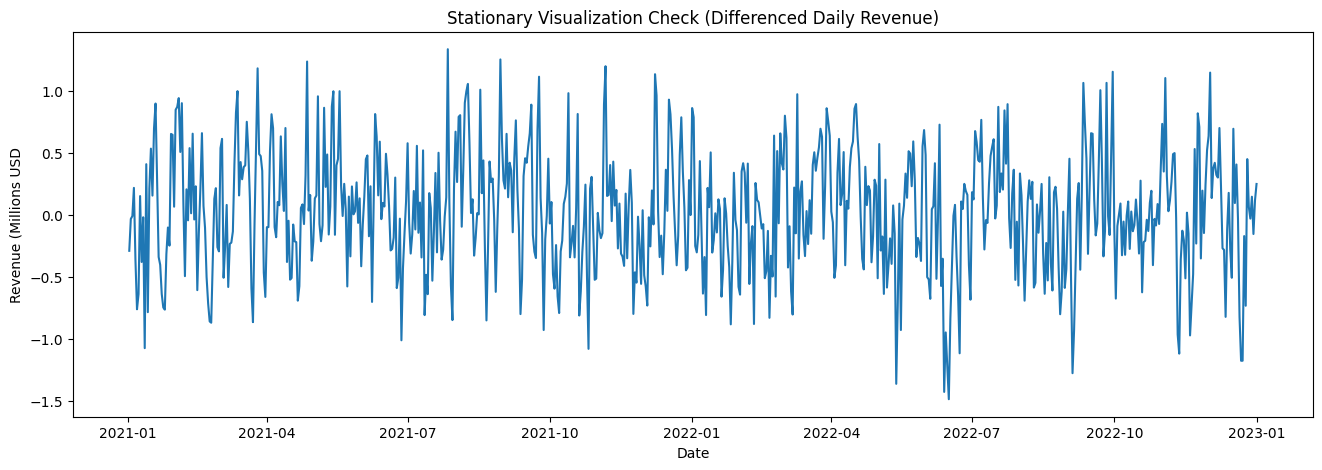

In [8]:
'''
Visual Check that Revenue Data is now Stationary
'''

plt.figure(figsize=(16,5))
plt.xlabel('Date')
plt.ylabel('Revenue (Millions USD')
plt.title('Stationary Visualization Check (Differenced Daily Revenue)')

plt.plot(discrete_differences)

This chart does not show any signs of trending or seasonality. The visual check confirms the p-value and adf value check of stationary.

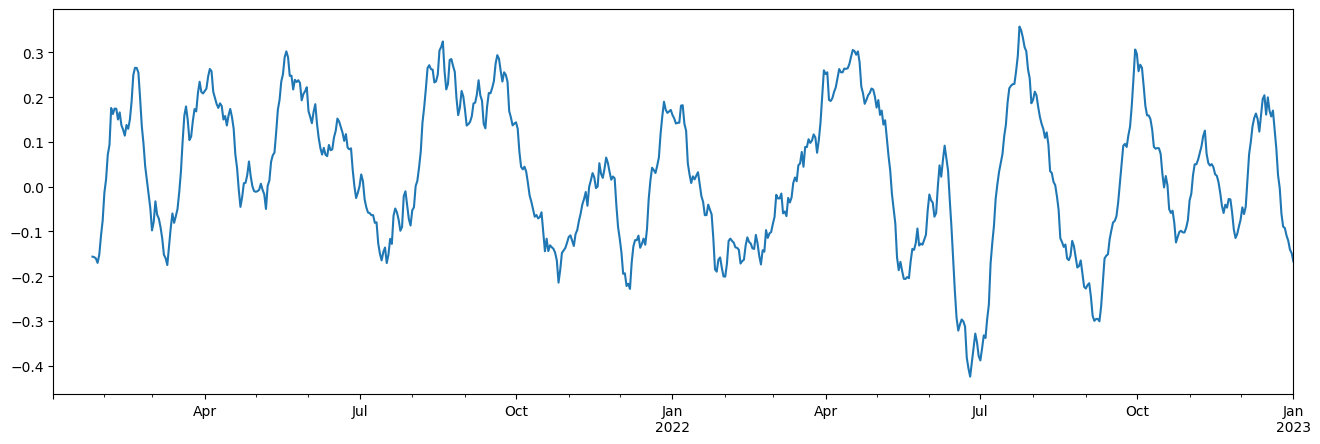

In [9]:
'''
Visually Plot Rolling Average of the Data Differences
'''

generate_rolling_plot(revenue_discrete_differences)

In [10]:
'''
Train and Test data splitting 80/20.
'''

training_data, testing_data = train_test_split(discrete_differences, test_size=.2, shuffle=False, random_state=999)

print('Training Data Top-Five')
print(training_data.head())
print('\n')
print('Testing Data Top-Five')
print(testing_data.head())

Training Data Top-Five
             Revenue
2021-01-02 -0.292356
2021-01-03 -0.035416
2021-01-04 -0.012215
2021-01-05  0.215100
2021-01-06 -0.366702


Testing Data Top-Five
             Revenue
2022-08-09  0.263991
2022-08-10 -0.588690
2022-08-11 -0.550427
2022-08-12  0.081477
2022-08-13 -0.146587


<a id="copy-of-prepared-data"></a>
## C5: Copy of Prepared Data Set

In [11]:
'''Saving Training Data'''
training_data.to_csv('./time-series-training-data.csv')

'''Saving Test Data'''
testing_data.to_csv('./time-series-testing-data.csv')


# Part IV: Model Identification & Analysis

<a id="annotated-findings-and-visualizations"></a>
## D1: Annotated Findings & Visualizations

Annotating the findings and supplying visualizations with those findings is going to include two processes:

 * [`auto_arima`](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)
    * **Purpose:** Forecasting
    * Automatically discover the optimal order for an ARIMA model
    * Uses SARIMAX Modeling
 * [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)
    * **Purpose:** Exploration / Decomposition
    * Seasonal decomposition using moving averages.

In [12]:
'''
Auto Generate the Optimal Order for an ARIMA Model

NOTE: Setting trace=True will allow us to see the different model runs before being returned the best option.
'''

auto_arima_results = auto_arima(revenue_discrete_differences, trace=True)
print(auto_arima_results.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1015.481, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=879.982, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=881.911, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=881.927, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=905.166, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=881.947, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.105 seconds
                               SA

The [`WGU Medical Time Series Dataset`](https://access.wgu.edu/ASP3/aap/content/fj30d8sm59fc83ed9xsi.zip) being processed through the [`auto_arima`](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) process concluded these results:

Optimal **[`ARIMA`](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) (AutoRegressive Integrated Moving Average) Model** parameters:

| Component               | Parameter                    | Optimal Value | Meaning                                                       |
|-------------------------|------------------------------|---------------|---------------------------------------------------------------|
| **AR** (AutoRegressive) | **p** (Autoregressive Order) | *1*           | Use 'First Lagged Value'                                      |
| **I** (Integrated)      | **d** (Differencing Order)   | *0*           | Data is stationary, directly models original time-series data |
| **MA** (Moving Average) | **q** (Moving Average Order) | *0*           | Will not use past forecast errors to model time-series        |


The optimal parameters (p, d, q) for our dataset have been identified as (1, 0, 0), representing the most favorable Akaike Information Criteria. Additionally, the aforementioned results indicate an absence of seasonality within our dataset. Subsequently, we will analyze the autocorrelation function and the partial autocorrelation function to further investigate any underlying trends or seasonality.

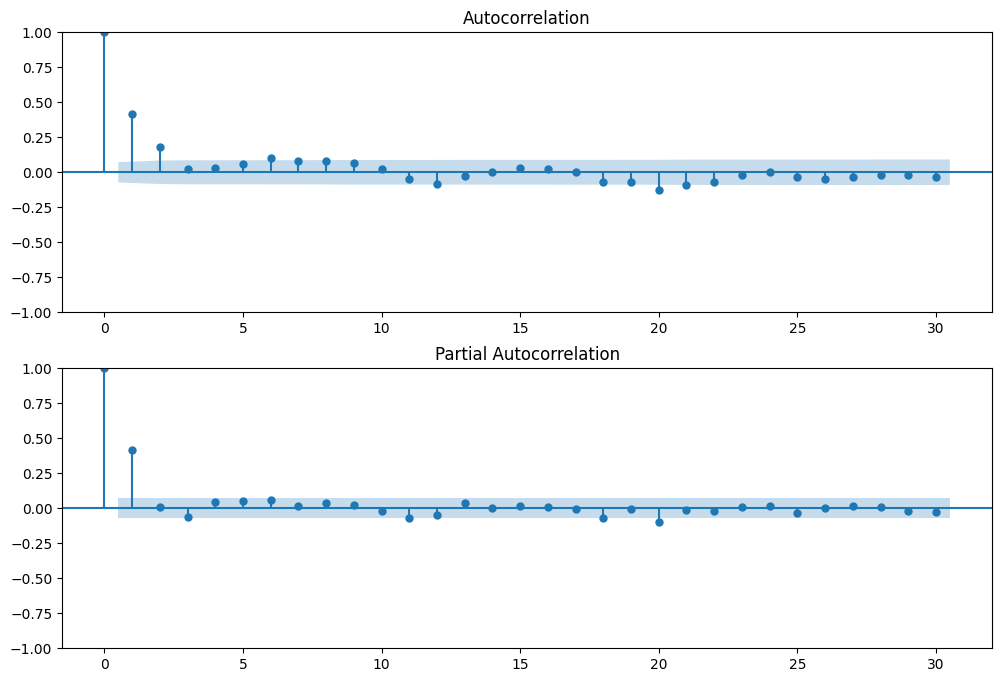

In [13]:
'''
Description:
    Raw Data Stationary Time Series, plot the difference in stationarity
'''

_, (axis1, axis2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(revenue_discrete_differences, ax=axis1, lags=30)
plot_pacf(revenue_discrete_differences, ax=axis2, lags=30, method='ywm')
plt.show()

#### Evaluating Spectral Density of Revenue Time Series

**Note:** [Periodogram Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html) 

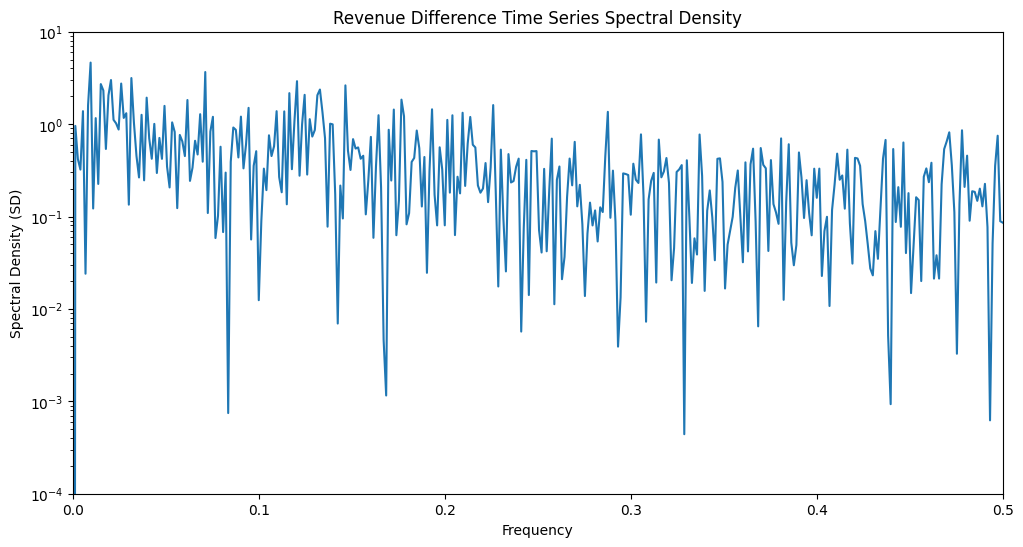

In [14]:
_, density_axis = plt.subplots(1, 1, figsize=(12, 6))
frequencies, power_spectral_density = signal.periodogram(revenue_discrete_differences)
density_axis.semilogy(frequencies, power_spectral_density)

#set x and y chart limits
plt.ylim([1e-4, 1e1])
plt.xlim([0, .5])

plt.xlabel('Frequency')
plt.ylabel('Spectral Density (SD)')
plt.title('Revenue Difference Time Series Spectral Density')
plt.show()

In [15]:
def chart_seasonal_decomposition(x_data: pd.Series, title: str, x_label: str, y_label: str, figure_size: tuple) -> None:
    """
    :param x_data: Data to show Seasonal Decomposition
    :type x_data: pd.Series 
     
    :param title: Chart Plot Title 
    :type title: str
    
    :param x_label: Label for the x-axis
    :type x_label: str
   
    :param y_label: Label for the y-axis
    :type y_label: str
   
    :param figure_size: Figure size to plot
    :type figure_size: tuple
   
    :return: None
    """
    seasonal_decomposition = seasonal_decompose(x_data)
    
    observed = seasonal_decomposition.observed
    trend = seasonal_decomposition.trend
    seasonal = seasonal_decomposition.seasonal
    residual = seasonal_decomposition.resid

    plt.figure(figsize=figure_size)

    plt.suptitle(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.subplot(4,1,1)
    plt.plot(observed, label='Original')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Revenue')
    
    plt.subplot(4,1,2)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Trend')

    plt.subplot(4,1,3)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Seasonality')
    
    plt.subplot(4,1,4)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    
    plt.subplots_adjust(hspace=.5, top=.9)
    plt.show()

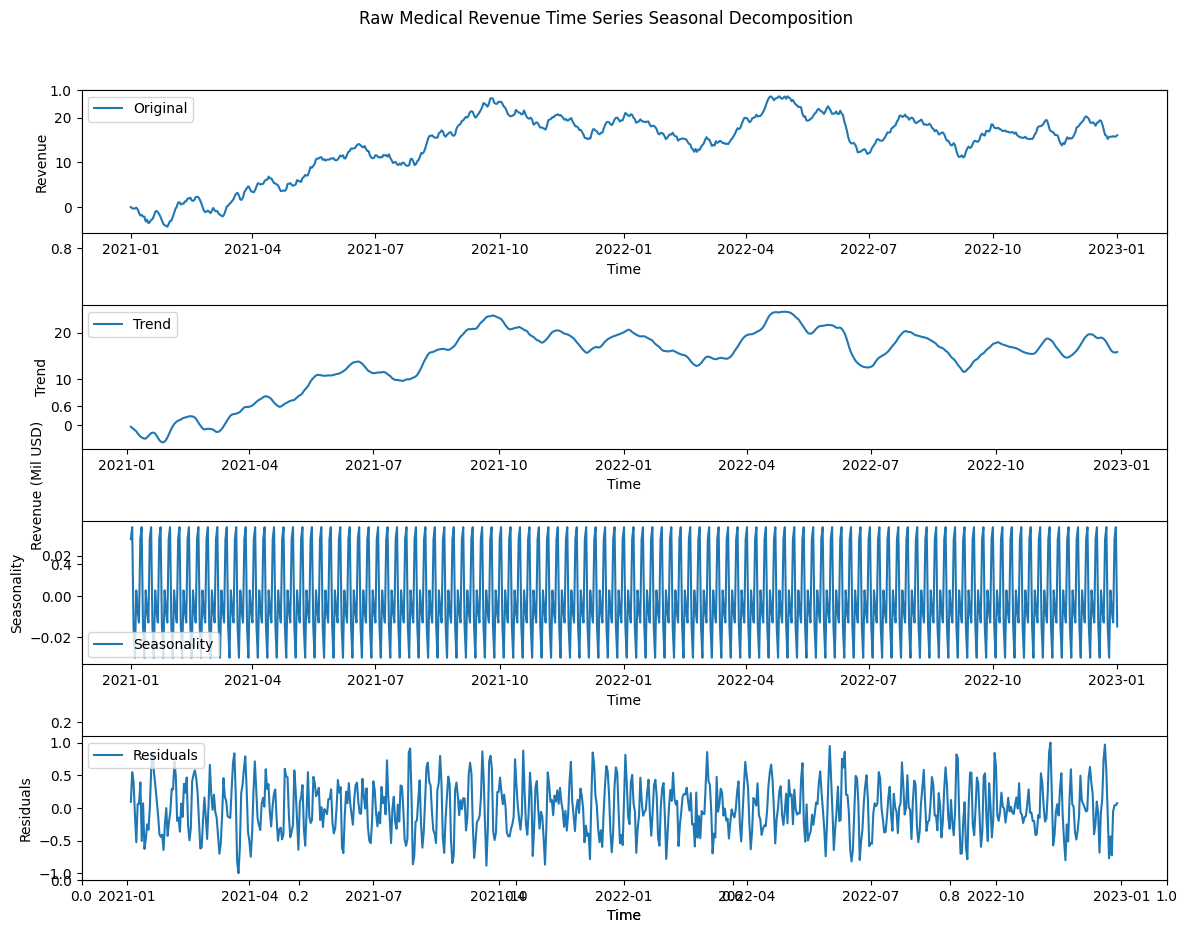

In [16]:
'''
Raw Revenue Data Decomposition
'''

revenue = medical_daily_revenue['Revenue']
chart_seasonal_decomposition(revenue, x_label='Time', y_label='Revenue (Mil USD)', title='Raw Medical Revenue Time Series Seasonal Decomposition', figure_size=(14, 10))


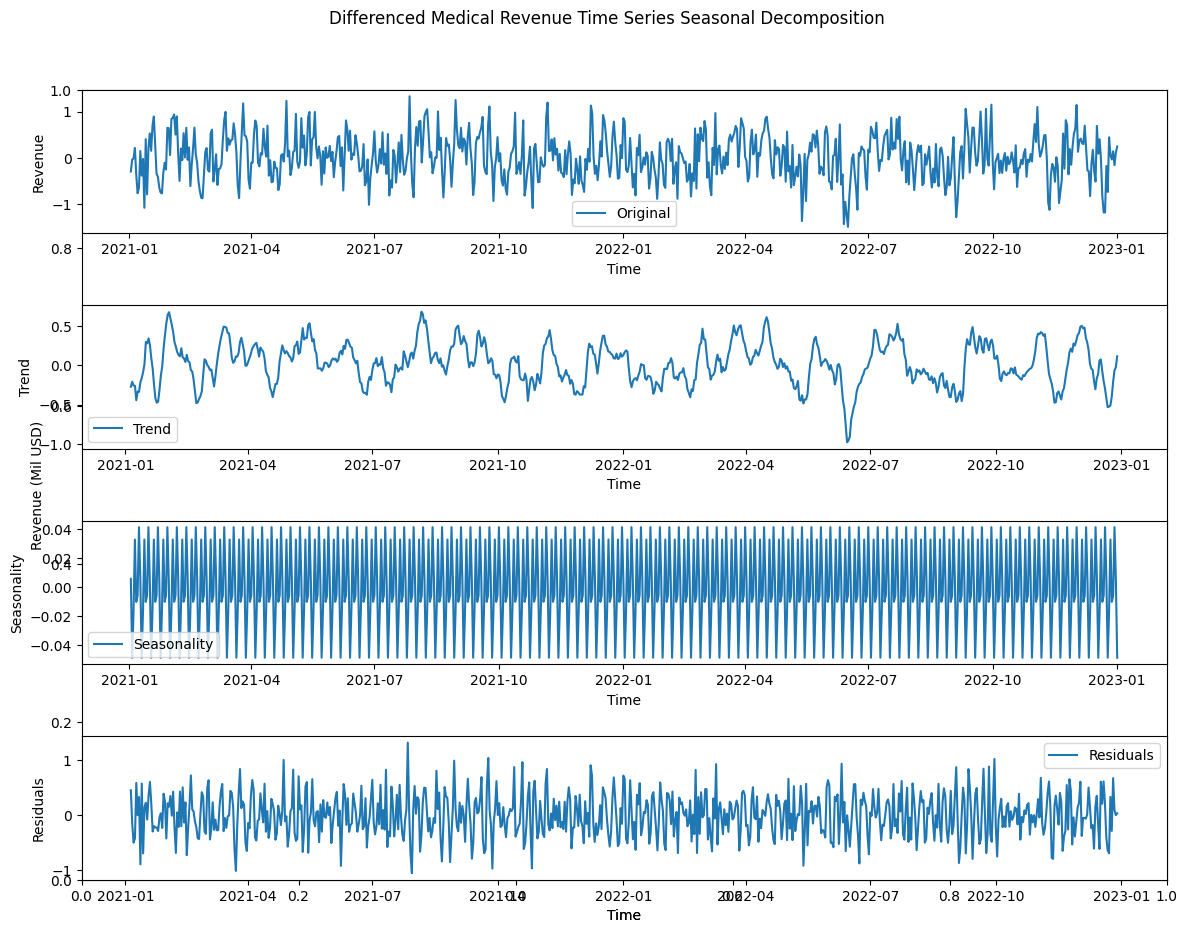

In [17]:
'''
Differenced Revenue Data Decomposition
'''

chart_seasonal_decomposition(discrete_differences, 
                                x_label='Time', 
                                y_label='Revenue (Mil USD)', 
                                title='Differenced Medical Revenue Time Series Seasonal Decomposition', 
                                figure_size=(14, 10)
                             )

<a id="arima-model-of-time-series-data"></a>
## D2: ARIMA Model of Time Series Data

In [18]:
p, d, q = auto_arima_results.order

#confirm the properties match the summary data above
assert p == 1, 'p(Autoregressive Order) should be [1] per D1 section summary'
assert d == 0, 'd(Differencing Order) should be [0] per D1 section summary'
assert q == 0, 'q(Moving Average Order) should be [0] per D1 section summary'

arima_order = (p, d, q)

arima_model = ARIMA(training_data, order=arima_order, freq='D')

fitted_model = arima_model.fit()

print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -350.349
Date:                Wed, 22 Nov 2023   AIC                            706.698
Time:                        10:15:20   BIC                            719.808
Sample:                    01-02-2021   HQIC                           711.808
                         - 08-08-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.031      1.063      0.288      -0.028       0.093
ar.L1          0.4079      0.038     10.748      0.000       0.333       0.482
sigma2         0.1943      0.012     15.948      0.0

<a id="forcast"></a>
## D3: Forecast



In [19]:
def plot_arima_forecast(model: ARIMA, training_data: pd.Series, testing_data: pd.Series, title: str, x_label: str, y_label: str, start_location: int, end_location: int, figure_size: tuple) -> None:
    """
    :param model: Pre-Fitted ARIMA Model 
    :type model: ARIMA
    
    :param training_data: Training data
    :type training_data: pd.Series
    
    :param testing_data: Test Data
    :param test_data: pd.Series
    
    :param title: The title for the plot
    :type title: str
    
    :param x_label: X-Axis label
    :type x_label: str
    
    :param y_label: Y-Axis label
    :type y_label: str    
    
    :param start_location: 
    :type start_location: int
    
    :param end_location: 
    :type end_location: int
    
    :param figure_size: 
    :type figure_size: tuple
    
    :return: None
    """
    
    _, axis = plt.subplots(figsize=figure_size)
    axis.set(title=title, xlabel=x_label, ylabel=y_label)
    axis.legend(['Training Data', 'Test Data', 'Predicted Data'])
    
    training_data.plot(ax=axis, linestyle='solid')
    testing_data.plot(ax=axis, linestyle='dotted', color=(.04, .91, .18))
    
    plot_predict(model, start=start_location, end=end_location, ax=axis, alpha=.05)
    
    training_last_date = training_data.index[-1] #Get last index
    training_last_revenue_value = float(training_data.iloc[-1]) #Get last value
    text_shift = .3
    
    annotation_color = (1, 0.12, 0)
    axis.annotate('Forecasting Start (Predictions)',
                  xy=(training_last_date, training_last_revenue_value), # (x, y) to annotate point.
                  xytext=(training_last_date, training_last_revenue_value + text_shift),     # (x, y) to annotate text point. 
                  arrowprops=dict(arrowstyle='->', lw=1.5, color=annotation_color),
                  fontsize=16,
                  color=annotation_color,
                  fontweight='bold',
                  ha='center')

    plt.savefig('./daily-medical-revenue-forcast.png')
    
    plt.show()

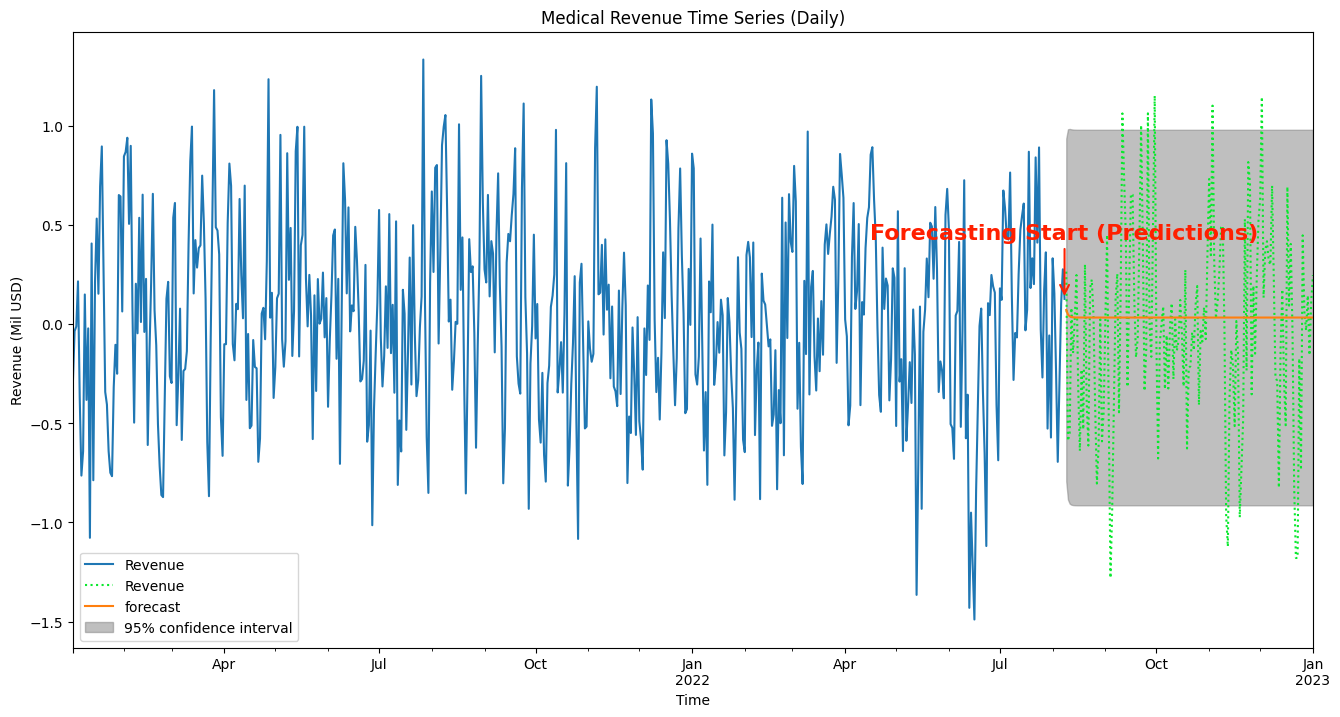

In [20]:
testing_data_start = len(training_data)
testing_data_end = (testing_data_start + len(testing_data)) - 1

plot_arima_forecast(fitted_model,
                    training_data=training_data,
                    testing_data=testing_data,
                    title='Medical Revenue Time Series (Daily)',
                    start_location=testing_data_start,
                    end_location=testing_data_end,
                    x_label='Time',
                    y_label='Revenue (Mil USD)',
                    figure_size=(16, 8))

<a id="analysis"></a>
## D4: Analysis Output & Calculations

This section will look at the specific values and calculations that have come back from the forecasting.

<a id="arima-code"></a>
## D5: ARIMA Model Code

### Because this Jupyter Notebook is acting as the paper and programming environment, please reference the code that is above.

In [21]:
'''
Display Prediction Values
'''

prediction_values = fitted_model.predict(start=testing_data_start, end=testing_data_end)
print(prediction_values)

2022-08-09    0.071071
2022-08-10    0.048405
2022-08-11    0.039159
2022-08-12    0.035388
2022-08-13    0.033850
                ...   
2022-12-28    0.032791
2022-12-29    0.032791
2022-12-30    0.032791
2022-12-31    0.032791
2023-01-01    0.032791
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


In [22]:
prediction_mean = prediction_values.mean()
mean_as_dollar = prediction_mean * 1000000
print(f'''
Prediction Values Mean:
Raw Value: {prediction_mean:.4f}
Dollar Value: ${mean_as_dollar:,.0f}
''')


Prediction Values Mean:
Raw Value: 0.0332
Dollar Value: $33,234


In [23]:
'''
RMSE (Root Mean Square Error) of ARIMA Model using Testing Data

Documentation: https://en.wikipedia.org/wiki/Root-mean-square_deviation
'''
mean_squared_error = mean_squared_error(testing_data, prediction_values)
root_mean_squared_error = np.sqrt(mean_squared_error)

print(f'''
    Mean Squared Error: {mean_squared_error}
    Root Square Mean Error: {root_mean_squared_error}
''')



    Mean Squared Error: 0.23885071879197742
    Root Square Mean Error: 0.48872356070889134


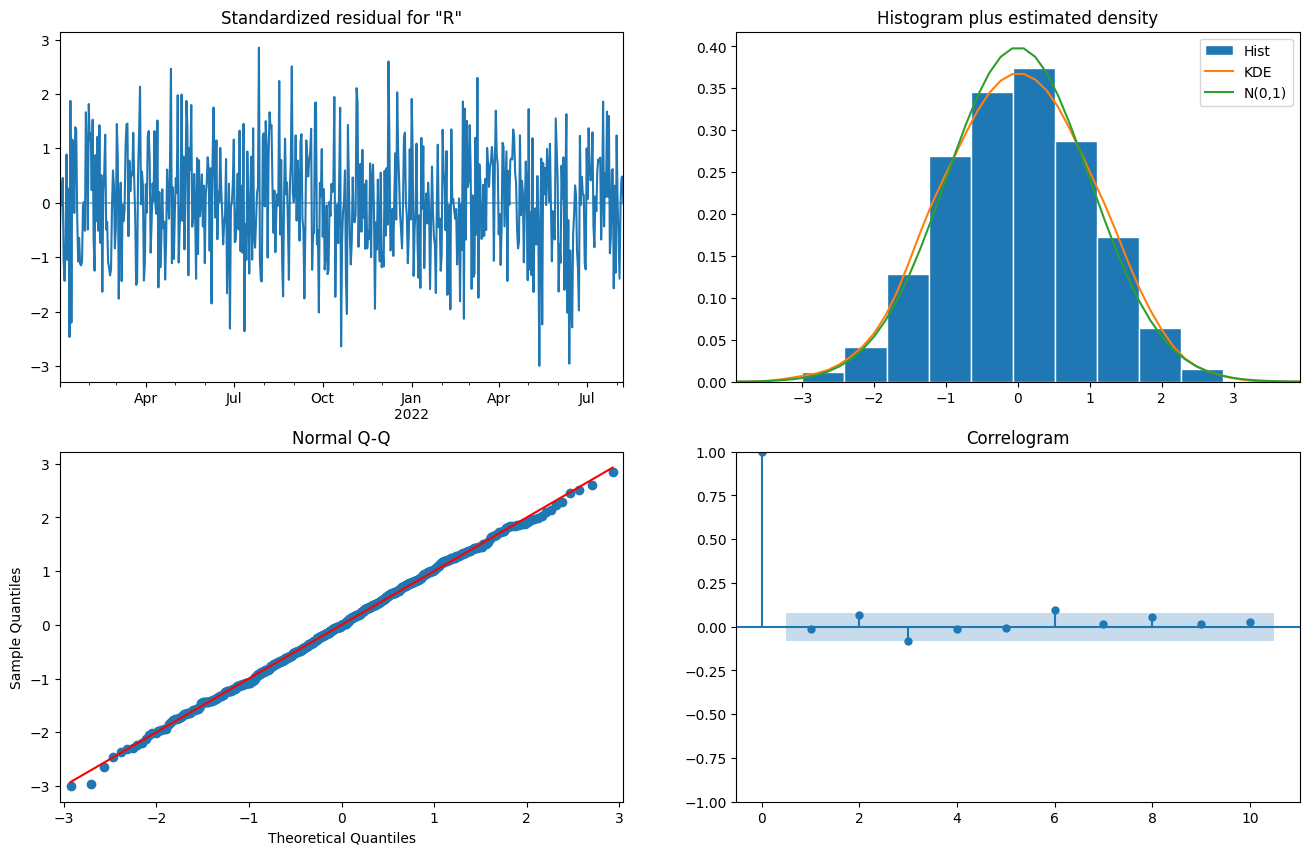

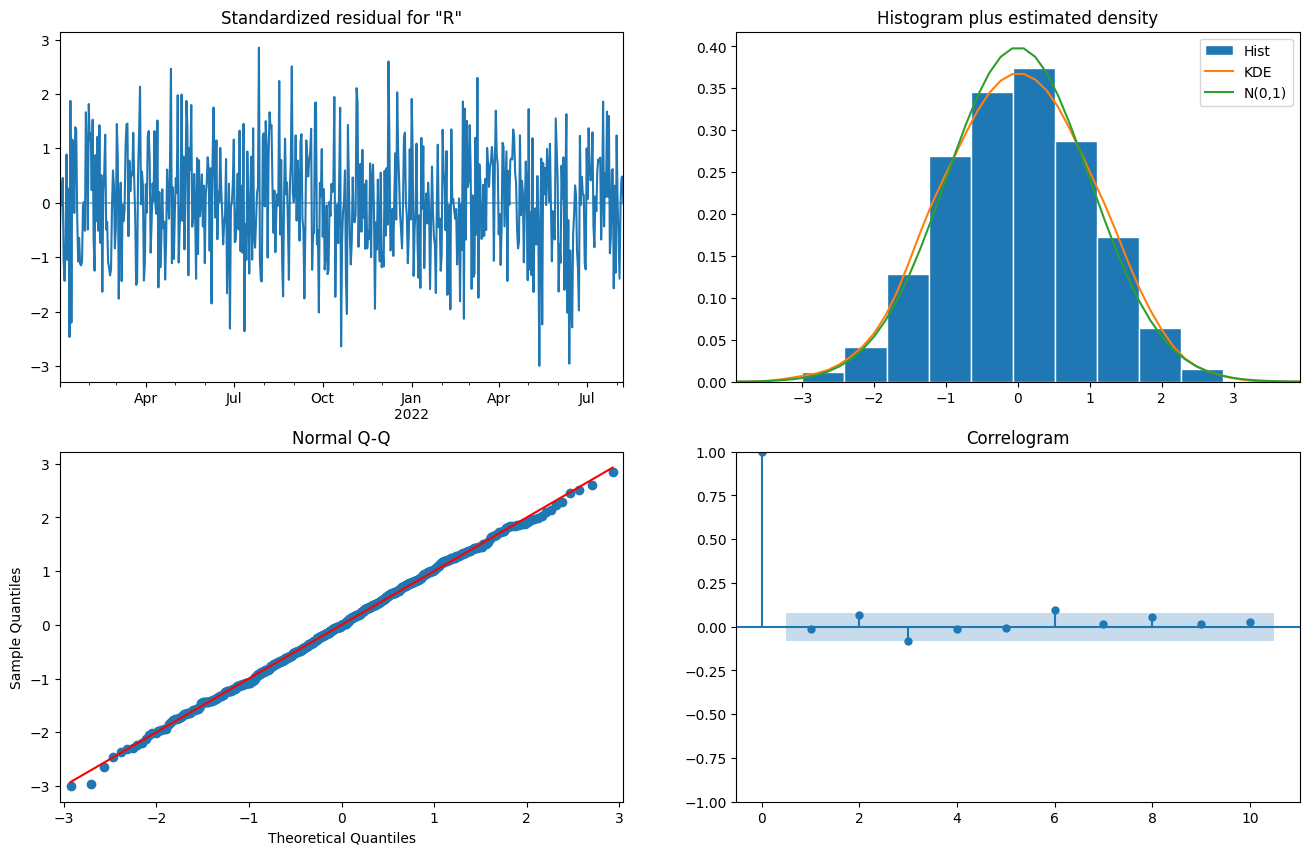

In [24]:
'''
Diagnostics Plots of ARIMA Model
'''

fitted_model.plot_diagnostics(figsize=(16, 10))

# Part V: Data Summary and Implications

<a id="results-of-analysis"></a>
## E1: Results of Analysis

| Section Title                            | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
|------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ARIMA Model Selection                    | The analysis utilized the AutoRegressive Integrated Moving Average (ARIMA) model due to its proficiency in managing time series data, notably exhibiting trends or seasonal fluctuations. Following the refinement and adjustment of the Medical Revenue dataset, the data attained a stationary state, a prerequisite for utilizing ARIMA. The choice of ARIMA (1, 0, 0) as the ideal model was validated by a process minimizing the Akaike Information Criteria (AIC), underscoring its simplicity and effectiveness for the data analyzed. |
| Forecast Prediction Intervals            | In the conducted analysis, the prediction interval encompassed the extent of the test dataset, accounting for 20% of the overall data or a duration of 146 days. This forecast duration was selected to ascertain an adequate sample size, thereby facilitating a thorough evaluation of the model's predictive accuracy and its generalizability to unobserved data.                                                                                                                                                                          |
| Justification of the Forecast Length     | The forecast length has been set to match the size of the test dataset, enabling a comprehensive assessment of our ARIMA model. This length furnishes sufficient data for validation purposes, while also ensuring that predictions are maintained within a trustworthy temporal frame, wherein the discerned patterns are anticipated to remain consistent.                                                                                                                                                                                   |
| ARIMA Model Evaluation and Error Metrics | The forecast length has been set to match the size of the test dataset, enabling a comprehensive assessment of our ARIMA model. This length furnishes sufficient data for validation purposes, while also ensuring that predictions are maintained within a trustworthy temporal frame, wherein the discerned patterns are anticipated to remain consistent.                                                                                                                                                                                   |


<a id="forcast-visualizations"></a>
## E2: Visualization of Forecast

#### The below-annotated chart was saved from the charting step in Section D3: Forecast

![`annotated-forecast`](./daily-medical-revenue-forcast.png)

<a id="recommendations"></a>
## E3: Recommended Action

Through this Performance Assessment it seems pretty clear that even with only two years of data that the ARIMA model did a pretty good job at forcasting future `WGU Medical Revenue`. Based on this the recommended actions are stated below.

 1. **Maintenance:** 
    * It is imperative to maintain the precision of the model's predictions amidst evolving business conditions. It is advisable to establish a routine for regular model updates and validations. As the organization accrues revenue data, leveraging this data to periodically retrain the ARIMA model is prudent. <br /> <br />
 2. **Model Re-Assessment:**
    * Moreover, a continual reassessment of the model's forecasting accuracy is essential. The employment of metrics such as RMSE has proven effective in gauging the model’s forecasting quality. Hence, adhering to a regular evaluation regimen using these metrics is vital to assure the model's sustained reliability. <br /> <br />
 3. **Introduce other models to increase accuracy and insights:**
    * Although the ARIMA model has yielded insightful outputs, exploring additional modeling techniques that either enhance or work in conjunction with the existing model may offer a more holistic and adaptive foresight into future revenues. It is significant to explore models that incorporate machine learning and neural networks, given their rising utility in predictive analysis. <br /> <br />      

<a id="reporting"></a>
## F: Reporting

> The report is accurately created in an industry-relevant interactive development environment. The PDF or HTML document of the executed notebook presentation is provided, is complete, and aligns with the data analysis of the report.

This D213 Performance Assessment Task 1 was completed as an all-in-one code and paper through Jupyter Notebook. A fully executed PDF version of a successful run will be submitted along with the `.ipynb` file.

<a id="code-references"></a>
## G: Code References

N/A

<a id="source-references"></a>
## H: Source References

 * Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. <br /><br />
 * Prabhakaran, S. (2022). Augmented Dickey Fuller Test (ADF Test) – must read guide. Machine Learning Plus. https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/ 